In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.api import OLS

In [2]:
train = pd.read_csv("data/train_merged.csv", parse_dates=["date"])
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,transactions,dcoilwtico,work_day,day_off
0,121497040,2017-07-08,46,1366213,2.0,False,HOME AND KITCHEN I,6257,0,Quito,Pichincha,A,14,4328,NaN,False,True
1,121497041,2017-07-08,46,1367273,9.0,False,HOME AND KITCHEN I,6212,0,Quito,Pichincha,A,14,4328,NaN,False,True
2,121497042,2017-07-08,46,1367438,2.0,False,HOME AND KITCHEN II,6330,0,Quito,Pichincha,A,14,4328,NaN,False,True
3,121497043,2017-07-08,46,1368456,1.0,False,HOME AND KITCHEN I,6267,0,Quito,Pichincha,A,14,4328,NaN,False,True
4,121497044,2017-07-08,46,1368488,1.0,False,HOME AND KITCHEN I,6269,0,Quito,Pichincha,A,14,4328,NaN,False,True


In [3]:
train.dtypes

id                       int64
date            datetime64[ns]
store_nbr                int64
item_nbr                 int64
unit_sales             float64
onpromotion               bool
family                  object
class                    int64
perishable               int64
city                    object
state                   object
type                    object
cluster                  int64
transactions             int64
dcoilwtico             float64
work_day                  bool
day_off                   bool
dtype: object

## Select "meaningful" columns
Remove `state`, `city` and `store_nbr` as these are represented by the proxy var `cluster`.
Remove `item_nbr` as this is described roughly by the proxy var `family`

We want to turn the following variables into a factor:
* `family`
* `class`
* `type`
* `cluster`

as well as all of the bool columns.

We need to process the following columns to fill missing values:
* `dcoilwtico`

We ignore `transactions`.
Also ignoring the time-series structure at this point.

Including `id` and `date` at this point too as they are useful for id/further analysis

In [4]:
# check base assumptions - this should be false
(train.work_day & train.day_off).any()

False

In [5]:
factor_cols = ["family", "type", "cluster", "class"]
numer_cols = ["unit_sales", "dcoilwtico"]
bool_cols = ["onpromotion", "perishable", "day_off"]

In [6]:
train[numer_cols].describe()

,unit_sales,dcoilwtico
count,4.000000e+06,2.767654e+06
mean,8.018128e+00,4.775121e+01
std,2.398207e+01,1.647307e+00
min,-2.410000e+02,4.440000e+01
25%,2.000000e+00,4.621000e+01
50%,4.000000e+00,4.777000e+01
75%,8.000000e+00,4.919000e+01
max,7.348000e+03,5.021000e+01


In [7]:
train[factor_cols].nunique()

family      33
type         5
cluster     17
class      322
dtype: int64

Class has too many levels to practically 1-hot encode - what are they? Can they be combined? Are describing the same thing as another column but more granularly? 

In [8]:
(train["class"].astype(str) + train["family"]).nunique()

322

Interesting to note - class is always a subtype of family (ie each level of class only belongs to one level of family)!

What's the mapping? Can we take advantage of it?

In [9]:
for fam in train.family.unique():
    print(f"{fam} has {train[train.family == fam]['class'].nunique()} levels of class")

HOME AND KITCHEN I has 20 levels of class
HOME AND KITCHEN II has 12 levels of class
PERSONAL CARE has 12 levels of class
GROCERY I has 65 levels of class
BEVERAGES has 21 levels of class
CLEANING has 26 levels of class
LIQUOR,WINE,BEER has 16 levels of class
BREAD/BAKERY has 15 levels of class
DAIRY has 22 levels of class
DELI has 13 levels of class
FROZEN FOODS has 11 levels of class
POULTRY has 3 levels of class
HOME CARE has 6 levels of class
PET SUPPLIES has 2 levels of class
PRODUCE has 19 levels of class
PLAYERS AND ELECTRONICS has 1 levels of class
CELEBRATION has 4 levels of class
SCHOOL AND OFFICE SUPPLIES has 6 levels of class
LADIESWEAR has 1 levels of class
AUTOMOTIVE has 5 levels of class
MEATS has 4 levels of class
MAGAZINES has 4 levels of class
EGGS has 3 levels of class
BOOKS has 1 levels of class
LAWN AND GARDEN has 6 levels of class
GROCERY II has 1 levels of class
PREPARED FOODS has 7 levels of class
BEAUTY has 5 levels of class
SEAFOOD has 5 levels of class
HARDWA

So about half of the `family` values should get a decent uplift by including `class`. 

I want to 1-hot encode these, so will ignore both `family` and `class` at this point as they consume too much ram once one-hot encoded

### Process the columns intoa more useful state

In [10]:
factor_cols = ["family", "type", "cluster"]
numer_cols = ["unit_sales", "dcoilwtico"]
bool_cols = ["onpromotion", "perishable", "day_off"]
id_cols = ["id", "date"]
cols = id_cols + factor_cols + numer_cols + bool_cols
train_sub = train[cols]

In [11]:
enc = OneHotEncoder()
enc.fit(train_sub[factor_cols])
factor_col_names = enc.get_feature_names_out()

In [12]:
# process bools into ints
train_sub = train_sub.astype({col: "int" for col in bool_cols})
# factorise factor cols
oh_encoded = enc.transform(train_sub[factor_cols])
train_sub = train_sub.drop(factor_cols, axis=1)
for i in range(oh_encoded.shape[1]):
    train_sub[factor_col_names[i]] = oh_encoded[:, i].A.flatten()

In [13]:
# randomly sample rows so that correlation computations are not horrifically expensive
rng = np.random.default_rng(seed=46290)
samp_idxs = rng.choice(train_sub.index, size=int(0.1*train_sub.shape[0]), replace=False)
train_sub_small = train_sub.loc[samp_idxs]

In [14]:
corrs = train_sub_small.drop(id_cols, axis=1).corr()
corrs

,unit_sales,dcoilwtico,onpromotion,perishable,day_off,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
unit_sales,1.000000,0.011148,0.105762,0.052925,0.027453,-0.013365,-0.002116,-0.009775,0.067455,-0.000948,...,0.025611,-0.023445,-0.014605,0.050110,-0.003070,-0.024966,0.042372,-0.030021,-0.016234,0.012012
dcoilwtico,0.011148,1.000000,-0.024436,0.001371,0.091136,-0.001012,0.000789,0.002305,-0.005993,0.003737,...,0.000992,-0.001067,-0.000452,0.002494,0.001506,-0.001940,0.000836,0.001008,0.001917,-0.002880
onpromotion,0.105762,-0.024436,1.000000,0.126293,-0.033447,-0.016705,-0.002758,0.011798,-0.033976,-0.001126,...,-0.016840,-0.006859,0.014890,-0.013866,0.007119,-0.013279,-0.017549,0.015592,0.004023,-0.007901
perishable,0.052925,0.001371,0.126293,1.000000,-0.007289,-0.028396,-0.004554,-0.022403,-0.255485,-0.001859,...,0.017825,0.017724,-0.005354,0.008038,-0.008309,0.017641,0.006984,-0.038117,0.003162,0.007559
day_off,0.027453,0.091136,-0.033447,-0.007289,1.000000,0.007206,-0.002178,0.002606,0.001390,-0.000611,...,-0.010379,-0.002558,0.014256,0.001656,-0.001642,-0.010581,0.003099,-0.009520,-0.000898,0.021354
family_AUTOMOTIVE,-0.013365,-0.001012,-0.016705,-0.028396,0.007206,1.000000,-0.000374,-0.001841,-0.020990,-0.000153,...,-0.001483,-0.004154,-0.002297,0.001568,-0.000627,0.000608,0.004144,0.004312,-0.003454,0.002462
family_BABY CARE,-0.002116,0.000789,-0.002758,-0.004554,-0.002178,-0.000374,1.000000,-0.000295,-0.003366,-0.000024,...,0.006719,-0.001509,0.001714,-0.002225,0.001509,-0.001126,-0.002595,-0.000805,-0.001053,-0.001176
family_BEAUTY,-0.009775,0.002305,0.011798,-0.022403,0.002606,-0.001841,-0.000295,1.000000,-0.016560,-0.000121,...,0.001626,-0.001819,-0.003965,0.001431,0.000673,-0.000293,0.004248,-0.002696,0.001714,0.002189
family_BEVERAGES,0.067455,-0.005993,-0.033976,-0.255485,0.001390,-0.020990,-0.003366,-0.016560,1.000000,-0.001374,...,-0.004998,-0.001423,0.000655,-0.001990,-0.001188,-0.001351,-0.002280,0.009822,0.002600,0.000672
family_BOOKS,-0.000948,0.003737,-0.001126,-0.001859,-0.000611,-0.000153,-0.000024,-0.000121,-0.001374,1.000000,...,0.002227,-0.000616,-0.001055,-0.000908,-0.000412,0.001949,0.001565,-0.000853,-0.000430,-0.000480


In [15]:
# which cols are correlated with unit_sales (target) most strongly?
corrs["unit_sales"].sort_values(ascending=False)[:10]

unit_sales          1.000000
onpromotion         0.105762
family_PRODUCE      0.095506
type_A              0.087631
family_BEVERAGES    0.067455
cluster_5           0.054873
perishable          0.052925
cluster_11          0.050110
cluster_14          0.042372
family_POULTRY      0.032415
Name: unit_sales, dtype: float64

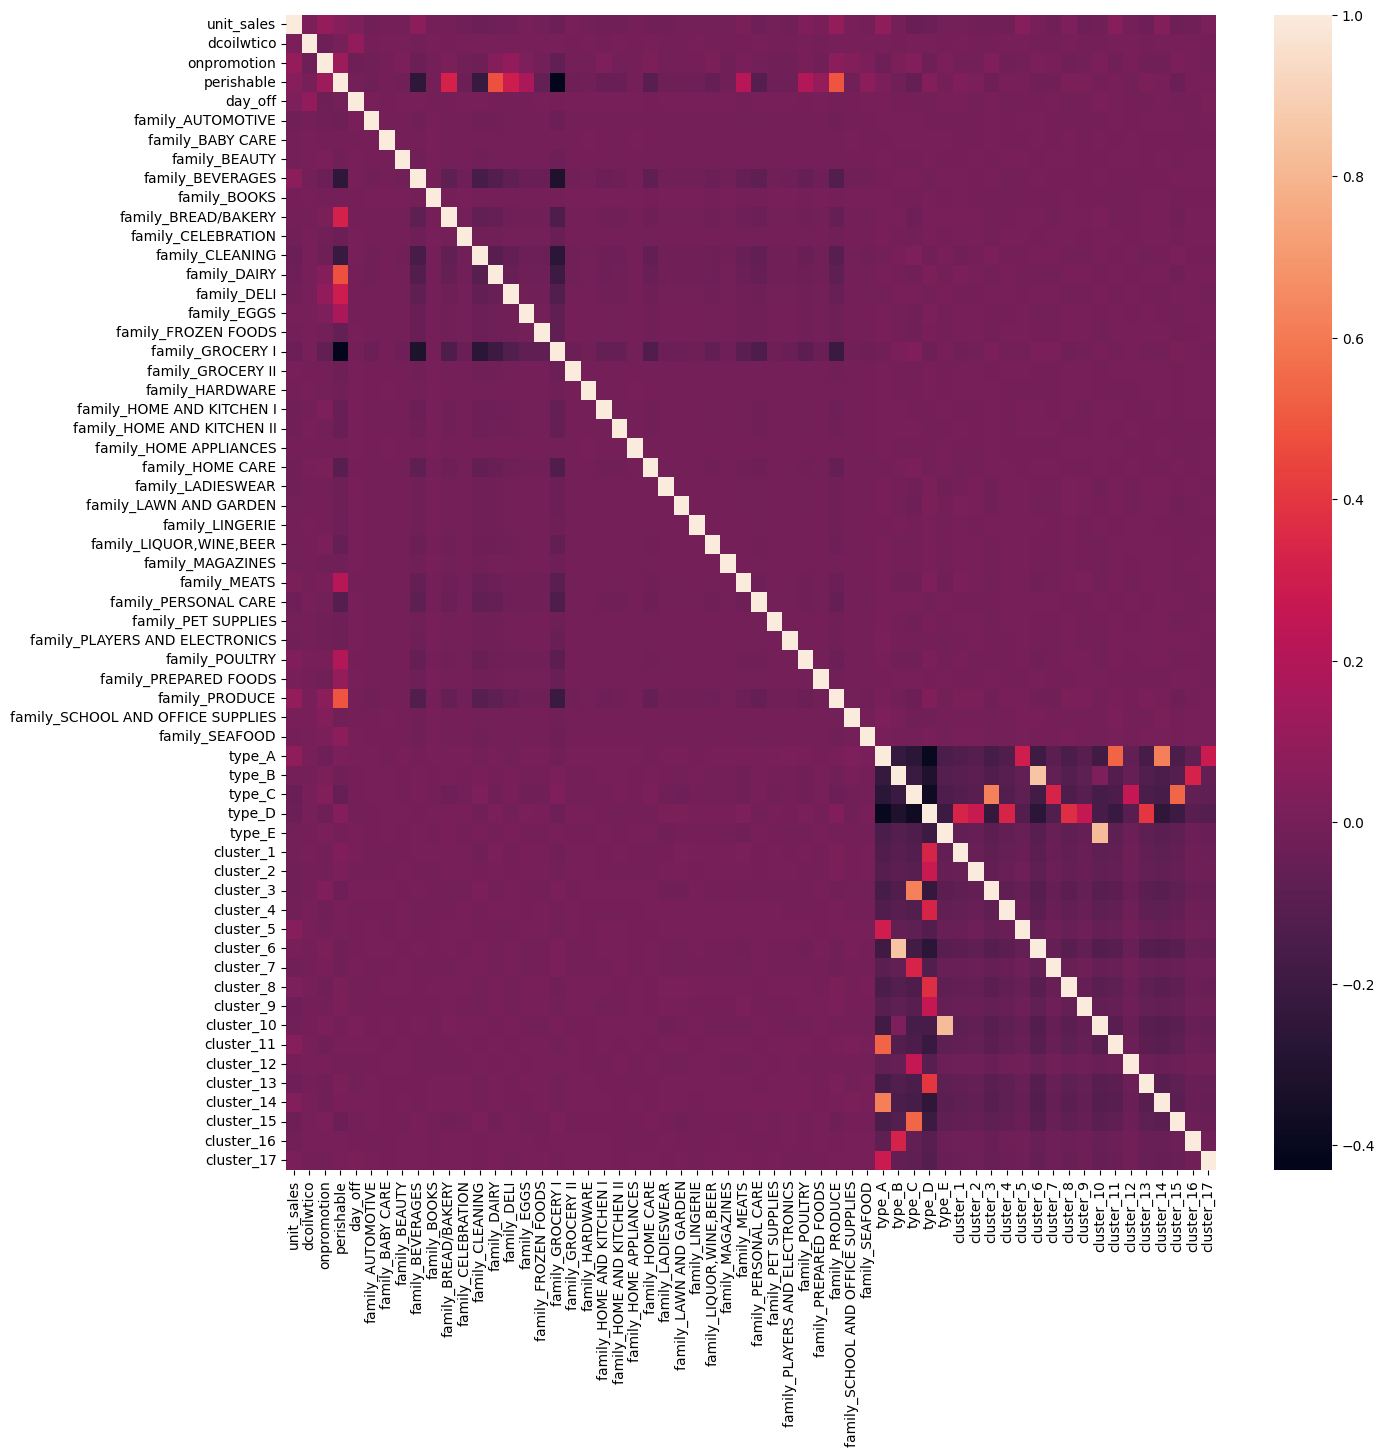

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(corrs)
plt.show()

Interesting that the `type` factors are all highly correlated with each other

Also - perishable is otherwise the most correlated column, can probably reduce the input size by including it!

In [ ]:
# quick OLS regression  - too many variables at this point!
model = OLS(train_sub_small.unit_sales, train_sub_small.drop("unit_sales", axis=1))
results = model.fit()
results.summary()